Introduction to using OCP in molecular simulations
==================================================

To introduce OCP we start with using it to calculate adsorption energies for a simple, atomic adsorbate where we specify the site we want to the adsorption energy for. Conceptually, you do this like you would do it with density functional theory. You create a slab model for the surface, place an adsorbate on it as an initial guess, run a relaxation to get the lowest energy geometry, and then compute the adsorption energy using reference states for the adsorbate.

You do have to be careful in the details though. Some OCP model/checkpoint combinations return a total energy like density functional theory would, but some return an "adsorption energy" directly. You have to know which one you are using.

# Calculating adsorption energies

Calculating adsorption energy with OCP
Adsorption energies are different than you might be used to in OCP. For example, you may want the adsorption energy of oxygen, and conventionally you would compute that from this reaction:

    1/2 O2 + slab -> slab-O

This is not what is done in OCP. It is referenced to a different reaction

    x CO + (x + y/2 - z) H2 + (z-x) H2O + w/2 N2 + * -> CxHyOzNw*

Here, x=y=w=0, z=1, so the reaction ends up as

    -H2 + H2O + * -> O*

or alternatively,

    H2O + * -> O* + H2

It is possible through thermodynamic cycles to compute other reactions. If we can look up rH1 below and compute rH2

    H2 + 1/2 O2 -> H2O  re1 = -3.03 eV
    H2O + * -> O* + H2  re2  # Get from OCP as a direct calculation

Then, the adsorption energy for

    1/2O2 + * -> O*  

is just re1 + re2.

Based on https://atct.anl.gov/Thermochemical%20Data/version%201.118/species/?species_number=986, the formation energy of water is about -3.03 eV at standard state. You could also compute this using DFT.

The first step is getting a checkpoint for the model we want to use. eSCN is currently the state of the art model. This next cell will download the checkpoint if you don't have it already.

In [1]:
import os
import requests

checkpoint = 'escn_l6_m3_lay20_all_md_s2ef.pt'

if not os.path.exists(checkpoint):
    url = 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt'
    with open(checkpoint, 'wb') as f:
        f.write(requests.get(url).content)

Next we load the checkpoint. The output is somewhat verbose, but it can be informative for debugging purposes. 

In [2]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint=os.path.expanduser(checkpoint), cpu=False)
# calc = OCPCalculator(checkpoint=os.path.expanduser(checkpoint), cpu=True)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/checkpoints/2023-07-16-21-00-48
  commit: ab7833d
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/logs/tensorboard/2023-07-16-21-00-48
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/results/2023-07-16-21-00-48
  seed: null
  timestamp_id: 2023-07-16-21-00-48
dataset: null
gpus: 1
logger: tensorboard
model: escn
model_attributes:
  basis_width_scalar: 2.0
  cutoff: 12.0
  distance_function: gaussian
  hidden_channels: 384
  lmax_list:
  - 6
  max_neighbors: 20
  mmax_list:
  - 3
  num_layers: 20
  num_sphere_samples: 128
  otf_graph: true
  regress_forces: true
  sphere_channels: 160
  use_pbc: true
noddp: false
optim:
  batch_size: 3
  clip_grad_norm: 20
  ema_decay: 0.999
  energy_coefficient: 4
  eval_batch_size: 3
  eval_every: 5000
  force_coefficient: 100
  loss_energy: mae
  loss_force: l2mae
  lr_gamma:

Next we can build a slab with an adsorbate on it. Here we use the ASE module to build a Pt slab. We use the experimental lattice constant that is the default. This can introduce some small errors with DFT since the lattice constant can differ by a few percent, and it is common to use DFT lattice constants. In this example, we do not constrain any layers.

In [3]:
from ase.build import fcc111, add_adsorbate
from ase.optimize import BFGS

In [4]:
re1 = -3.03

slab = fcc111('Pt', size=(2, 2, 5), vacuum=10.0)
add_adsorbate(slab, 'O', height=1.2, position='fcc')

slab.set_calculator(calc)
opt = BFGS(slab)
opt.run(fmax=0.05, steps=100)
slab_e = slab.get_potential_energy()
slab_e + re1

      Step     Time          Energy         fmax
BFGS:    0 21:00:58        1.731244        1.6980
BFGS:    1 21:00:59        1.530763        0.9678
BFGS:    2 21:00:59        1.354577        0.7142
BFGS:    3 21:00:59        1.302485        0.7958
BFGS:    4 21:00:59        0.870476        0.7217
BFGS:    5 21:00:59        0.814818        0.4914
BFGS:    6 21:00:59        0.785898        0.5975
BFGS:    7 21:00:59        0.773748        0.7437
BFGS:    8 21:01:00        0.757873        0.5324
BFGS:    9 21:01:00        0.746731        0.1296
BFGS:   10 21:01:00        0.738483        0.0418


-2.2915166306495665

It is good practice to look at your geometries to make sure they are what you expect.

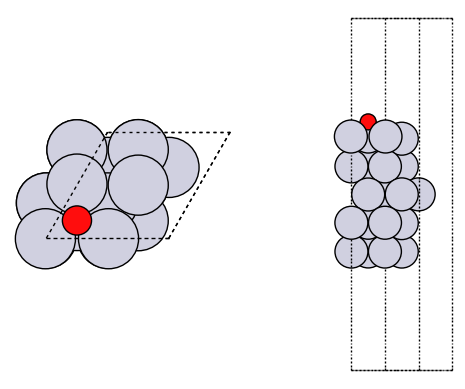

In [5]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(1, 2)
plot_atoms(slab, axs[0]);
plot_atoms(slab, axs[1], rotation=('-90x'))
axs[0].set_axis_off()
axs[1].set_axis_off()

How did we do? We need a reference point. In the paper below, there is an atomic adsorption energy for O on Pt(111) of about -4.264 eV. This is for the reaction O + * -> O*. To convert this to the dissociative adsorption energy, we have to add the reaction:

    1/2 O2 -> O   D = -2.58 eV (expt)

to get a comparable energy of about -1.68 eV. There is about ~0.6 eV difference to account for. The biggest difference is likely due to the differences in exchange-correlation functional. The reference data used the PBE functional, and eSCN was trained on *RPBE* data. To additional places where there are differences include:

1. Difference in lattice constant
2. The reference energy used for the experiment references. These can differ by up to 0.5 eV from comparable DFT calculations.

These differences tend to be systematic, and you can calibrate and correct these, especially if you can augment these with your own DFT calculations. 

### Exercises

1. Explore the effect of the lattice constant on the adsorption energy.
2. Try different sites, including the bridge and top sites. Compare the energies, and inspect the resulting geometries.


# Coverage dependent adsorption energies

Xu, Z., & Kitchin, J. R. (2014). Probing the coverage dependence of site and adsorbate configurational correlations on (111) surfaces of late transition metals. J. Phys. Chem. C, 118(44), 25597–25602. http://dx.doi.org/10.1021/jp508805h

[Supporting information](https://pubs.acs.org/doi/suppl/10.1021/jp508805h/suppl_file/jp508805h_si_001.pdf).

These are atomic adsorption energies:

    O + * -> O*

We have to do some work to get comparable numbers from OCP

    H2 + 1/2 O2 -> H2O  re1 = -3.03 eV
    H2O + * -> O* + H2  re2   # Get from OCP
    O -> 1/2 O2         re3 = -2.58 eV

Then, the adsorption energy for

    O + * -> O*  

is just re1 + re2 + re3.

Here we just look at the fcc site on Pt. First, we get the data stored in the paper.

Next we get the structures and compute their energies. Some subtle points are that we have to account for stoichiometry, and normalize the adsorption energy by the number of oxygens.

First we get a reference energy from the paper (PBE, 0.25 ML O on Pt(111)).

In [6]:
import json

with open('energies.json') as f:
    edata = json.load(f)
    
edata['Pt']['O']['fcc']['0.25']

-4.263842000000002

Next, we load data from the SI to get the geometry to start from.

In [7]:
with open('structures.json') as f:
    s = json.load(f)
    
sfcc = s['Pt']['O']['fcc']['0.25']    

Next, we construct the atomic geometry, run the geometry optimization, and compute the energy.

In [8]:
re3 = -2.58  # O -> 1/2 O2         re3 = -2.58 eV

from ase import Atoms

atoms = Atoms(sfcc['symbols'],
              positions=sfcc['pos'],
              cell=sfcc['cell'],
              pbc=True)
    
atoms.set_calculator(calc)
opt = BFGS(atoms)

opt.run(fmax=0.05, steps=100)
re2 = atoms.get_potential_energy()
    
nO = 0
for atom in atoms:
    if atom.symbol == 'O':
        nO += 1
        re2 += re1 + re3

print(re2 / nO)

      Step     Time          Energy         fmax
BFGS:    0 21:01:01        0.609397        0.3370
BFGS:    1 21:01:01        0.612063        0.2935
BFGS:    2 21:01:01        0.602140        0.0915
BFGS:    3 21:01:01        0.595091        0.0732
BFGS:    4 21:01:01        0.597267        0.0880
BFGS:    5 21:01:02        0.594175        0.0841
BFGS:    6 21:01:02        0.595432        0.0670
BFGS:    7 21:01:02        0.592953        0.0700
BFGS:    8 21:01:02        0.593922        0.0375
-5.0160782790184015


## Site correlations

This cell reproduces a portion of a figure in the paper. We compare oxygen adsorption energies in the fcc and hcp sites across metals and coverages. These adsorption energies are highly correlated with each other because the adsorption sites are so similar.

At higher coverages, the agreement is not as good. This is likely because the model is extrapolating and needs to be fine-tuned.

In [9]:
from tqdm import tqdm
import time

t0 = time.time()

data = {'fcc': [],
       'hcp': []}

refdata = {'fcc': [],
           'hcp': []}


for metal in ['Cu', 'Ag', 'Pd', 'Pt', 'Rh', 'Ir']:
    print(metal)
    for site in ['fcc', 'hcp']:
        for adsorbate in ['O']:
            for coverage in tqdm(['0.25']):
                 
                
                entry = s[metal][adsorbate][site][coverage]
                
                atoms = Atoms(entry['symbols'],
                              positions=entry['pos'],
                              cell=entry['cell'],
                              pbc=True)
    
                atoms.set_calculator(calc)
                opt = BFGS(atoms, logfile=None)  # no logfile to suppress output

                opt.run(fmax=0.05, steps=100)
                
                re2 = atoms.get_potential_energy()
                nO = 0
                for atom in atoms:
                    if atom.symbol == 'O':
                        nO += 1
                        re2 += re1 + re3
                
                data[site] += [re2 / nO]
                refdata[site] += [edata[metal][adsorbate][site][coverage]]  
                
f'Elapsed time = {time.time() - t0} seconds'            

Cu


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Ag


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Pd


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Pt


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Rh


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Ir


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


'Elapsed time = 9.982844591140747 seconds'

First, we compare the computed data and reference data. There is a systematic difference of about 0.5 eV due to the difference between RPBE and PBE functionals, and other subtle differences like lattice constant differences and reference energy differences. This is pretty typical, and an expected deviation.

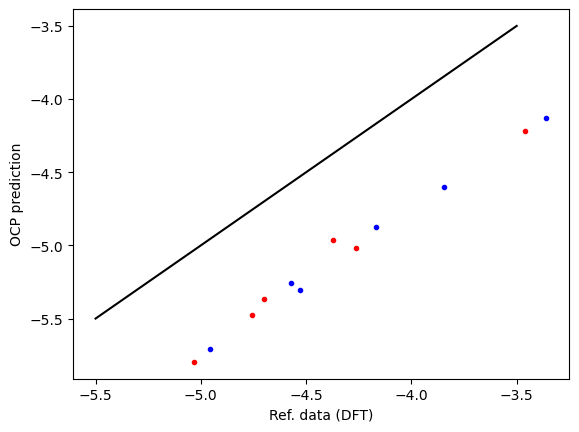

In [10]:
plt.plot(refdata['fcc'], data['fcc'], 'r.', label='fcc')
plt.plot(refdata['hcp'], data['hcp'], 'b.', label='hcp')
plt.plot([-5.5, -3.5], [-5.5, -3.5], 'k-')
plt.xlabel('Ref. data (DFT)')
plt.ylabel('OCP prediction');

Next we compare the correlation between the hcp and fcc sites. Here we see the same trends. The data falls below the parity line because the hcp sites tend to be a little weaker binding than the fcc sites.

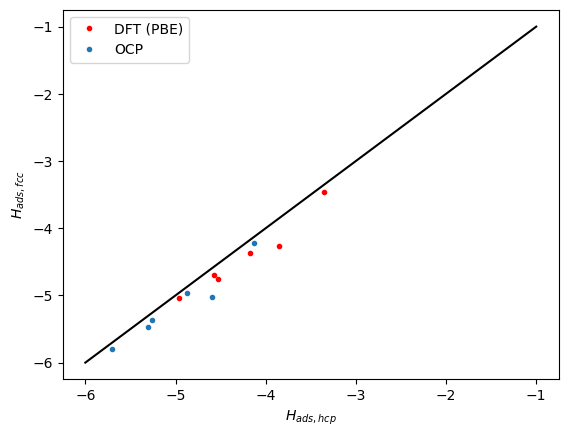

In [11]:
plt.plot(refdata['hcp'], refdata['fcc'], 'r.')
plt.plot(data['hcp'], data['fcc'], '.')
plt.plot([-6, -1], [-6, -1], 'k-')
plt.xlabel('$H_{ads, hcp}$')
plt.ylabel('$H_{ads, fcc}$')
plt.legend(['DFT (PBE)', 'OCP']);

### Exercises

1. You can also explore a few other adsorbates: C, H, N. 
2. Explore the higher coverages. The deviations from the reference data are expected to be higher, but relative differences tend to be better.

# Next steps

In the next step, we consider some more complex adsorbates in nitrogen reduction, and how we can leverage OCP to automate the search for the most stable adsorbate geometry. See [the next step](./NRR/NRR_example.ipynb).